# TEXT SUMMERIZATION - LUHN ALGORITHM

**1. Preprocessing the texts**

In [41]:
# pip install matplotlib
# pip install wordcloud
# pip install spacy
# !python -m spacy download en_core_web_sm

In [42]:
import re # regular expressions
import nltk # natural language toolkit
import string # for string operations
import heapq # for finding n largest elements
from IPython.core.display import HTML # for displaying HTML in Jupyter Notebook
from goose3 import Goose # for extracting text from web pages
from rouge_score import rouge_scorer
import feedparser
from bs4 import BeautifulSoup
import os
import json
from wordcloud import WordCloud # for generating word clouds
import matplotlib.pyplot as plt # for plotting graphs
import spacy # for advanced NLP tasks
from spacy import displacy

In [43]:
original_text = """Artificial intelligence is human like intelligence machines.
                   It is the study of intelligent artificial agents.
                   Science and engineering to produce intelligent machines.
                   Solve problems and have intelligence.
                   Related to intelligent behavior machines.
                   Developing of reasoning machines.
                   Learn from mistakes and successes.
                   Artificial intelligence is related to reasoning in everyday situations."""

In [44]:
original_text = re.sub(r'\s+', ' ', original_text)  # remove extra spaces and newlines
original_text

'Artificial intelligence is human like intelligence machines. It is the study of intelligent artificial agents. Science and engineering to produce intelligent machines. Solve problems and have intelligence. Related to intelligent behavior machines. Developing of reasoning machines. Learn from mistakes and successes. Artificial intelligence is related to reasoning in everyday situations.'

In [45]:
stopwords = nltk.corpus.stopwords.words('english')  # get the list of stopwords in English
print(stopwords)
len(stopwords)  # number of stopwords
print(string.punctuation)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [46]:
def preprocess(text): 
    formatted_text = text.lower()
    tokens = []
    # tokenize the text using word tokenizer 
    for token in nltk.word_tokenize(formatted_text, language="english", preserve_line=False): 
        tokens.append(token)
    #print(tokens)
    tokens = [word for word in tokens if word not in stopwords and word not in string.punctuation] # remove stopwords and punctuation from the text 
    formatted_text = " ".join(element for element in tokens)  # join the tokens back to string
    
    return formatted_text

In [47]:
formatted_text = preprocess(original_text)
formatted_text

'artificial intelligence human like intelligence machines study intelligent artificial agents science engineering produce intelligent machines solve problems intelligence related intelligent behavior machines developing reasoning machines learn mistakes successes artificial intelligence related reasoning everyday situations'

**2. Function to calculate sentences score**

In [48]:
def calculate_sentences_score(sentences, important_words, distance): 
    scores = []
    sentence_index = 0
    
    for sentence in [nltk.word_tokenize(sentence) for sentence in sentences]: # tokenize each sentence
        # print("---------")
        # print("Words in each Sentence: ", sentence)
        
        word_index = []
        for word in important_words: 
            # print("Important word: ", word)
            try: 
                word_index.append(sentence.index(word))
            except ValueError:
                pass 
        word_index.sort()
        # print("Word Indexes: ", word_index) # indexes of important words in the sentence
        
        if len(word_index) == 0:
            continue
        
        # [0, 1, 2, 5, 8, 9]
        group_list = [] # list of groups of important words
        group = [word_index[0]] # current group of important words
        
        i = 1 # 3
        while i < len(word_index): # 3
            # first execution: 1 - 0
            # second execution: 2 - 1
            # third execution: 5 - 2
            if word_index[i] - word_index[i-1] < distance: 
                group.append(word_index[i])
                # print("Group after append: ", group)
            else: 
                group_list.append(group[:])
                group = [word_index[i]]
                # print("New Group: ", group)
            i += 1
            
        group_list.append(group) # append the last group
        # print("Group List: ", group_list)
            
        # calculate the score for each group
        max_group_score = 0
        for g in group_list: 
            # print(g)
            important_words_in_group = len(g)
            total_words_in_group = g[-1] - g[0] + 1 # total words in the group  
            score = 1.0 * (important_words_in_group ** 2) / total_words_in_group # multiplied by one in order to have the value in the same scale 
            # print("Score: ", score)
            
            if score > max_group_score:
                max_group_score = score
            
        scores.append((max_group_score, sentence_index))
        sentence_index += 1
        
    return scores

**6. Function to summarize the texts**

In [49]:
def summarize(text, top_n_words, distance, number_of_sentences, percantage=0):
    original_setences = [sentence for sentence in nltk.sent_tokenize(text)] # tokenize the text into sentences
    # print("Before Preprocessing text: ", original_setences)
    formatted_sentences = [preprocess(original_sentence) for original_sentence in original_setences] # preprocess each sentence
    # print("After Preprocessing text: ", formatted_sentences)
    words = [word for sentence in formatted_sentences for word in nltk.word_tokenize(sentence)] # tokenize the preprocessed sentences into words
    # print("Tokenized words: ", words)
    frequency = nltk.FreqDist(words) # get the frequency distribution of the words
    # return frequency
    top_n_words = [word[0] for word in frequency.most_common(top_n_words)] # get the top n words
    # print("Top n words: ", top_n_words)
    sentences_score = calculate_sentences_score(formatted_sentences, top_n_words, distance)
    # print("Score in each sentence (score, sentence_index): ", sentences_score)
    if percantage > 0:
        best_sentences = heapq.nlargest(int(len(formatted_sentences) * percantage), sentences_score)
    else: 
        best_sentences = heapq.nlargest(number_of_sentences, sentences_score)
    # print("Best sentences (score, sentence_index): ", best_sentences)
    best_sentences = [original_setences[i] for (score, i) in best_sentences]
    # print(best_sentences)
    return original_setences, best_sentences, sentences_score

In [50]:
original_setences, best_sentences, sentences_score = summarize(original_text, 5, 2, 3)

In [51]:
text = " "
display(HTML(f"<h2>Summary</h2>"))
for sentence in original_setences:
    if sentence in best_sentences: 
        text += sentence.replace(sentence, f"<mark>{sentence}</mark>")
    else: 
        text += " " + sentence
display(HTML(f"""{text}"""))

**7. Extracting articles from RSS feeds**

AI feeds: https://blog.feedspot.com/ai_rss_feeds/

In [52]:
!pip install feedparser

In [53]:
url = "https://aitrends.com/feed/"
feed = feedparser.parse(url)

In [54]:
feed.entries[0]

{'title': 'Best Practices for Building the AI Development Platform in Government',
 'title_detail': {'type': 'text/plain',
  'language': None,
  'base': 'https://www.aitrends.com/feed/',
  'value': 'Best Practices for Building the AI Development Platform in Government'},
 'links': [{'rel': 'alternate',
   'type': 'text/html',
   'href': 'https://www.aitrends.com/ai-world-government/best-practices-for-building-the-ai-development-platform-in-government/'}],
 'link': 'https://www.aitrends.com/ai-world-government/best-practices-for-building-the-ai-development-platform-in-government/',
 'authors': [{'name': 'Allison Proffitt'}],
 'author': 'Allison Proffitt',
 'author_detail': {'name': 'Allison Proffitt'},
 'published': 'Thu, 28 Oct 2021 23:20:17 +0000',
 'published_parsed': time.struct_time(tm_year=2021, tm_mon=10, tm_mday=28, tm_hour=23, tm_min=20, tm_sec=17, tm_wday=3, tm_yday=301, tm_isdst=0),
 'tags': [{'term': 'AI World Government', 'scheme': None, 'label': None},
  {'term': 'Ethics a

In [55]:
for e in feed.entries:
    print(e.title)
    print(e.content[0].value)


Best Practices for Building the AI Development Platform in Government
<img alt="" class="webfeedsFeaturedVisual wp-post-image" height="70" src="https://www.aitrends.com/wp-content/uploads/2021/10/10-29SoftwareDev-ArmedServices-2-100x70.jpeg" style="float: left; margin-right: 5px;" width="100" /><p><i><span>By John P. Desmond, AI Trends Editor</span></i><span> </span></p>
<p><span>The AI stack defined by Carnegie Mellon University is fundamental to the approach being taken by the US Army for its AI development platform efforts, according to Isaac Faber, Chief Data Scientist at the US Army AI Integration Center, speaking at the </span><a href="https://www.aiworldgov.com/"><span>AI World Government</span></a><span> event held in-person and virtually from Alexandria, Va., last week.</span><span> </span><span> </span></p>
<figure class="wp-caption alignleft" id="attachment_21162" style="width: 168px;"><img alt="" class="size-full wp-image-21162" height="289" src="https://www.aitrends.com/wp

In [56]:
# remove HTML tags from the content
def clean_html(text):
    if text == "":
        return ""
    else: 
        return BeautifulSoup(text, "html.parser").get_text() 

In [57]:
clean_html(e.content[0].value)

'By Lance Eliot, the AI Trends Insider\xa0\xa0\xa0\xa0\nAre there things that we must not know?\xa0\xa0\xa0\nThis is an age-old question.\xa0Some assert that there is the potential for knowledge that ought to not be known. In other words, there are ideas, concepts, or mental formulations that should we become aware of that knowledge it could be our downfall. The discovery or invention of some new innovation or way of thinking could be unduly dangerous. It would be best to not go there, as it were, and avoid ever landing on such knowledge: forbidden knowledge.\xa0\xa0\xa0\nThe typical basis for wanting to forbid the discovery or emergence of forbidden knowledge is that the adverse consequences are overwhelming.\xa0The end result is so devastating and undercutting that the bad side outweighs the good that could be derived from the knowledge.\xa0\xa0\xa0\nIt is conceivable that there might be knowledge that is so bad that it has no good possibilities at all. Thus, rather than trying to ba

In [58]:
articles = []
for e in feed.entries:
    articles.append({"title": e.title, "content": clean_html(e.content[0].value)})

In [59]:
articles

[{'title': 'Best Practices for Building the AI Development Platform in Government',
  'content': 'By John P. Desmond, AI Trends Editor\xa0\nThe AI stack defined by Carnegie Mellon University is fundamental to the approach being taken by the US Army for its AI development platform efforts, according to Isaac Faber, Chief Data Scientist at the US Army AI Integration Center, speaking at the\xa0AI World Government\xa0event held in-person and virtually from Alexandria, Va., last week.\xa0\xa0\nIsaac Faber, Chief Data Scientist, US Army AI Integration Center\n“If we want to move the Army from legacy systems through digital modernization, one of the biggest issues I have found is the difficulty in abstracting away the differences in applications,” he said. “The most important part of digital transformation is the middle layer, the platform that makes it easier to be on the cloud or on a local computer.” The desire is to be able to move your software platform to another platform, with the same

In [60]:
save_file = os.path.join("articles.json") # save articles to a JSON file in the machine 
feed = open(save_file, "w+" )
feed.write(json.dumps(articles, indent=1))
feed.close()

In [61]:
blog_articles = json.load(open("articles.json")) # read the articles from the JSON file
blog_articles

[{'title': 'Best Practices for Building the AI Development Platform in Government',
  'content': 'By John P. Desmond, AI Trends Editor\xa0\nThe AI stack defined by Carnegie Mellon University is fundamental to the approach being taken by the US Army for its AI development platform efforts, according to Isaac Faber, Chief Data Scientist at the US Army AI Integration Center, speaking at the\xa0AI World Government\xa0event held in-person and virtually from Alexandria, Va., last week.\xa0\xa0\nIsaac Faber, Chief Data Scientist, US Army AI Integration Center\n“If we want to move the Army from legacy systems through digital modernization, one of the biggest issues I have found is the difficulty in abstracting away the differences in applications,” he said. “The most important part of digital transformation is the middle layer, the platform that makes it easier to be on the cloud or on a local computer.” The desire is to be able to move your software platform to another platform, with the same

**8. Word cloud**

In [62]:
feed_content = ""
for article in blog_articles:
    feed_content += article["title"] + "\n"
    feed_content += article["content"] + "\n"
feed_content

'Best Practices for Building the AI Development Platform in Government\nBy John P. Desmond, AI Trends Editor\xa0\nThe AI stack defined by Carnegie Mellon University is fundamental to the approach being taken by the US Army for its AI development platform efforts, according to Isaac Faber, Chief Data Scientist at the US Army AI Integration Center, speaking at the\xa0AI World Government\xa0event held in-person and virtually from Alexandria, Va., last week.\xa0\xa0\nIsaac Faber, Chief Data Scientist, US Army AI Integration Center\n“If we want to move the Army from legacy systems through digital modernization, one of the biggest issues I have found is the difficulty in abstracting away the differences in applications,” he said. “The most important part of digital transformation is the middle layer, the platform that makes it easier to be on the cloud or on a local computer.” The desire is to be able to move your software platform to another platform, with the same ease\xa0with\xa0which a n

In [63]:
formatted_feed_content = preprocess(feed_content) # remove stopwords and punctuation
formatted_feed_content

'best practices building ai development platform government john p. desmond ai trends editor ai stack defined carnegie mellon university fundamental approach taken us army ai development platform efforts according isaac faber chief data scientist us army ai integration center speaking ai world government event held in-person virtually alexandria va. last week isaac faber chief data scientist us army ai integration center “ want move army legacy systems digital modernization one biggest issues found difficulty abstracting away differences applications ” said “ important part digital transformation middle layer platform makes easier cloud local computer. ” desire able move software platform another platform ease new smartphone carries user ’ contacts histories ethics cuts across layers ai application stack positions planning stage top followed decision support modeling machine learning massive data management device layer platform bottom “ advocating think stack core infrastructure way a

In [64]:
len(feed_content), len(formatted_feed_content)

(103131, 72256)

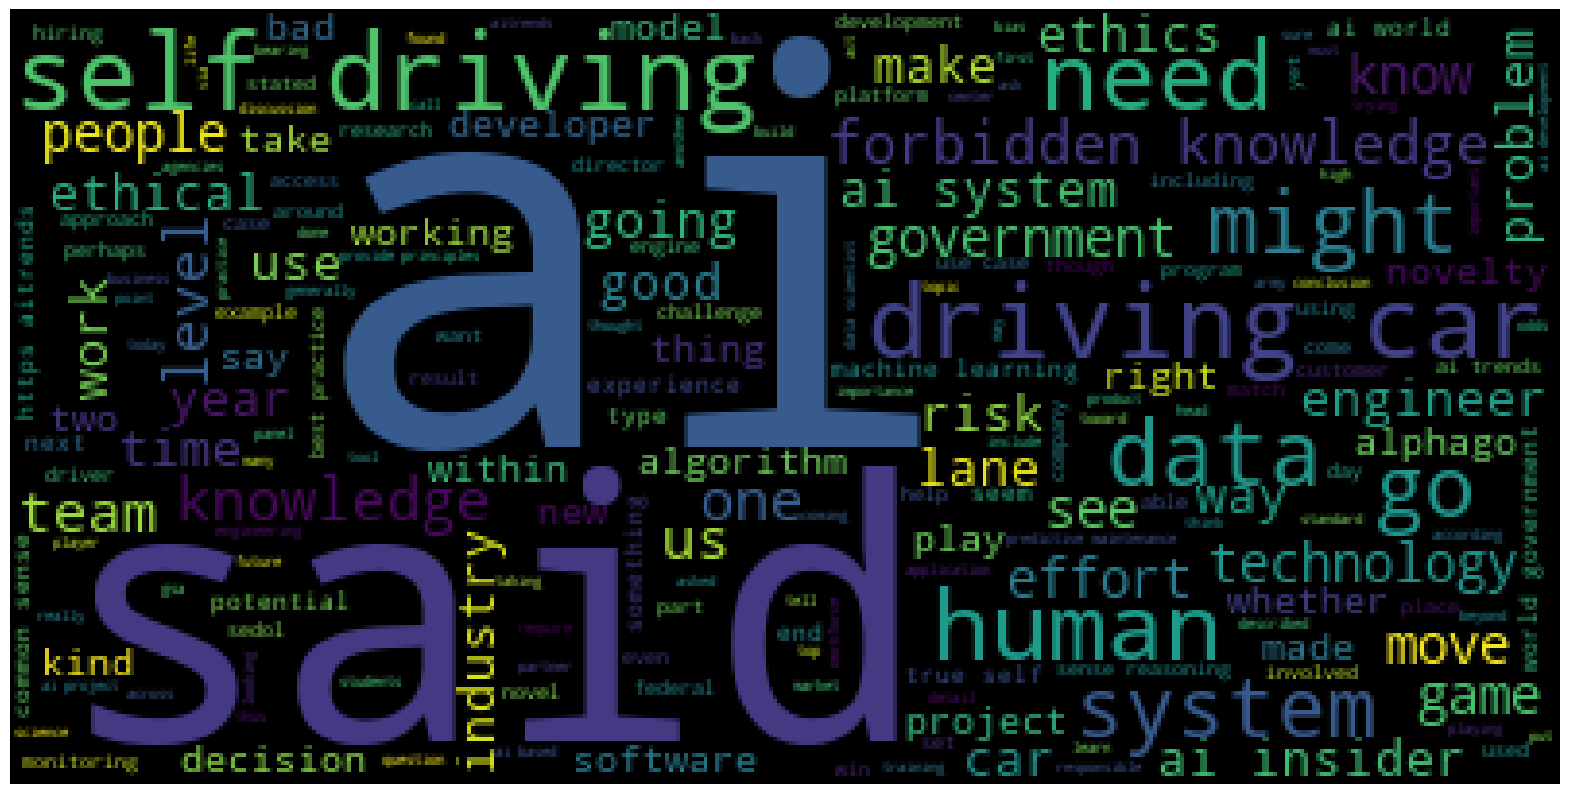

In [65]:
plt.figure(figsize=(20,20)) # seeing word count in this article feed
plt.imshow(WordCloud().generate(formatted_feed_content)) 
plt.axis("off")
plt.show()

**9. Extracting named entities**

Acronyms: https://spacy.io/api/annotation/#named-entities

In [66]:
nlp = spacy.load("en_core_web_sm")
nlp

In [67]:
displacy.render(nlp(blog_articles[0]["content"]), style="ent", jupyter=True)

**10. Summarizing the articles**

In [68]:
def visualize(title, best_sentences, original_sentences):
    """
    Display the article title and highlight the best sentences in the summary.
    - title: str, the article title
    - best_sentences: list of str, the selected summary sentences
    - original_sentences: list of str, all sentences in the article (in order)
    """
    text = ""
    for sentence in original_sentences:
        if sentence in best_sentences:
            text += f"<mark>{sentence}</mark> "
        else:
            text += f"{sentence} "
    html = f"<h2>{title}</h2><p>{text}</p>"
    display(HTML(html))

In [69]:
# To summarize each article in the feed using Luhn Algorithm
for article in blog_articles:
    original_setences, best_sentences, sentences_score = summarize(article["content"], 150, 10, number_of_sentences=5, percantage=0.5)

**11. Saving the summary**

In [70]:
def save_summary(title, original_sentences, best_sentences): 
    HTML_TEMPLATE = """
    <html>
    <head><title>Summary</title></head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8"/>
    <body>
    {1}
    </body>
    </html>
    """
    text = ''
    for sentence in original_sentences:
        if sentence in best_sentences:
            text += str(sentence).replace(sentence, f"<mark>{sentence}</mark>")
        else:
            text += sentence

    save_file = open(os.path.join(title + '.html'), 'wb')
    html_file = HTML_TEMPLATE.format(title, text)
    save_file.write(html_file.encode('utf-8'))
    save_file.close()

In [71]:
visualize(article["title"], best_sentences, original_setences)
save_summary(article["title"], original_setences, best_sentences)

**12. Evaluation**

In [72]:
# human text summary for anamoly detection article
test_text = """Anomaly detection is the identification of items, events or observations which do not conform to an expected pattern or other items in a dataset. In a broader sense, the term anomaly detection is often used interchangeably with outlier detection. Anomalies are also referred to as novelties, outliers, exceptions, aberrations, surprises, peculiarities or contaminants. Anomaly detection has a wide variety of applications. For example, in network security, the goal is to identify rare items or events which raise suspicions by differing significantly from the majority of the data. This is based on the assumption that these anomalies may be indicative of a malicious activity such as a cyberattack. In finance, anomalies can indicate fraudulent transactions. In industrial damage detection, anomalies can indicate a fault or defect in a machine. In healthcare, anomalies can indicate an abnormality in medical images or patient data."""
human_summary = """Anomaly detection is the identification of items, events or observations which do not conform to an expected pattern or other items in a dataset. Anomaly detection has a wide variety of applications. In finance, anomalies can indicate fraudulent transactions. In healthcare, anomalies can indicate an abnormality in medical images or patient data."""
sentence_list, best_sentences, sentence_scores = summarize(test_text, top_n_words=3, distance=5, number_of_sentences=3)
luhn_summary = " ".join(best_sentences)
print("\nLuhn Summary:\n", luhn_summary)
visualize(
    "Anomaly Detection Article Summary",
    best_sentences,        # summary sentences
    sentence_list          # full article sentences
)


Luhn Summary:
 In finance, anomalies can indicate fraudulent transactions. Anomaly detection has a wide variety of applications. In a broader sense, the term anomaly detection is often used interchangeably with outlier detection.


In [73]:
from rouge_score import rouge_scorer

# Print summaries (optional but good for debugging)
print("SYSTEM SUMMARY:\n", luhn_summary)
print("\nHUMAN SUMMARY:\n", human_summary)

# ROUGE scorer
scorer = rouge_scorer.RougeScorer(
    ['rouge1', 'rouge2', 'rougeL'],
    use_stemmer=True
)

scores = scorer.score(human_summary, luhn_summary)

for metric, result in scores.items():
    print(f"\n{metric.upper()}:")
    print(f" Precision: {result.precision:.4f}")
    print(f" Recall:    {result.recall:.4f}")
    print(f" F1:        {result.fmeasure:.4f}")

SYSTEM SUMMARY:
 In finance, anomalies can indicate fraudulent transactions. Anomaly detection has a wide variety of applications. In a broader sense, the term anomaly detection is often used interchangeably with outlier detection.

HUMAN SUMMARY:
 Anomaly detection is the identification of items, events or observations which do not conform to an expected pattern or other items in a dataset. Anomaly detection has a wide variety of applications. In finance, anomalies can indicate fraudulent transactions. In healthcare, anomalies can indicate an abnormality in medical images or patient data.

ROUGE1:
 Precision: 0.7000
 Recall:    0.4038
 F1:        0.5122

ROUGE2:
 Precision: 0.5862
 Recall:    0.3333
 F1:        0.4250

ROUGEL:
 Precision: 0.3667
 Recall:    0.2115
 F1:        0.2683
